In [8]:
import torch 
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import cv2
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from IPython.display import Image
from torchvision.utils import save_image


In [9]:
mnist = MNIST(root = 'Trainig_data/',
             train = True,
             download = True, 
             transform = Compose([ToTensor(), Normalize(mean=(0.5), std = (0.5,))]))

In [10]:
def denorm(x):
    out = (x+1) / 2
    return out.clamp(0, 1)

In [11]:
# Device Configuring for better performance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
img, label = mnist[0] 

In [13]:
%matplotlib inline # this is magic command
i = denorm(img) 
plt.imshow(i[0], cmap = 'gray')
print('Label: ', label)

UsageError: unrecognized arguments: # this is magic command


In [14]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [15]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle = True)


batch size is some thing that is we are taking batches of 100 each so total batches will be 70000/100 i.e 700

50th batch
torch.Size([1, 28, 28])
tensor([5, 9, 0, 2, 1, 8, 5, 1, 0, 1, 3, 1, 5, 8, 9, 7, 9, 8, 0, 3, 0, 3, 6, 0,
        4, 1, 0, 8, 1, 0, 9, 9, 0, 3, 9, 0, 9, 7, 2, 1, 9, 5, 6, 0, 0, 4, 8, 4,
        2, 9, 6, 4, 4, 4, 2, 1, 4, 4, 7, 3, 2, 1, 4, 9, 2, 2, 8, 9, 4, 6, 4, 1,
        8, 0, 1, 3, 5, 5, 6, 8, 9, 7, 8, 9, 8, 1, 9, 1, 3, 6, 6, 3, 7, 2, 7, 2,
        7, 4, 1, 7])


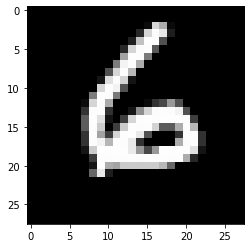

In [16]:
for img_batch, label_batch in data_loader:
    print('50th batch')
    print(img_batch[50].shape)
    plt.imshow(img_batch[50][0], cmap = 'gray')
    print( label_batch )
    break

In [17]:
img_size = 784
hidden_size = 512

In [18]:
D = nn.Sequential(
    nn.Linear(img_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [19]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=512, out_features=1, bias=True)
  (5): Sigmoid()
)

In [20]:
latent_size = 64

In [21]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, img_size),
    nn.Tanh())
  

In [22]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=784, bias=True)
  (5): Tanh()
)

In [23]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr = 0.0002)

In [24]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
    

In [25]:
def train_discriminator(img):
    # Created the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    #loss for real images
    outputs = D(img)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    #loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_scores = outputs
    
    #combine losses
    d_loss = d_loss_real + d_loss_fake
    
    #Reset Gradients
    reset_grad()
    
    # Compute gradients
    d_loss.backward()
    
    #Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_scores

In [26]:
x = 15
for fake_images in range(x):
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    D(fake_images)
    print(denorm(fake_images))

tensor([[0.4066, 0.5514, 0.4893,  ..., 0.3546, 0.5962, 0.5029],
        [0.4118, 0.5783, 0.5105,  ..., 0.4424, 0.5510, 0.5082],
        [0.3717, 0.4553, 0.5442,  ..., 0.4306, 0.5032, 0.4814],
        ...,
        [0.4390, 0.4857, 0.5228,  ..., 0.4536, 0.5346, 0.4648],
        [0.4237, 0.4389, 0.4591,  ..., 0.4782, 0.5697, 0.4755],
        [0.3917, 0.4710, 0.5033,  ..., 0.4923, 0.5581, 0.4577]],
       device='cuda:0', grad_fn=<ClampBackward>)
tensor([[0.4376, 0.4871, 0.4905,  ..., 0.4052, 0.5567, 0.5548],
        [0.4487, 0.4559, 0.4854,  ..., 0.4152, 0.5862, 0.4363],
        [0.4634, 0.4754, 0.4764,  ..., 0.3772, 0.5839, 0.5075],
        ...,
        [0.4309, 0.5347, 0.4805,  ..., 0.4561, 0.5300, 0.5209],
        [0.4235, 0.4489, 0.5307,  ..., 0.4315, 0.5577, 0.4410],
        [0.3682, 0.4817, 0.4937,  ..., 0.4697, 0.5484, 0.4415]],
       device='cuda:0', grad_fn=<ClampBackward>)
tensor([[0.4395, 0.4872, 0.4740,  ..., 0.4806, 0.5384, 0.5432],
        [0.4576, 0.4536, 0.5217,  ..., 0.3

In [27]:
def train_generator():
    # Generate fake images and calculation loss
    z = torch.randn(batch_size, latent_size). to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)
    
    
    #Backprop and optimizer
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images
    

In [28]:
import os 
sample_dir = 'samples/'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

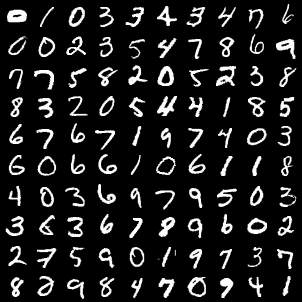

In [29]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), 
                os.path.join(sample_dir, 'real_images.png'), 
                nrow = 10)
    
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


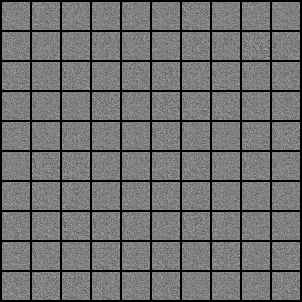

In [30]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [31]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0228, g_loss: 5.8571, D(x): 0.99, D(G(z)): 0.01
Epoch [0/300], Step [400/600], d_loss: 0.0386, g_loss: 6.7999, D(x): 1.00, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.0252, g_loss: 6.1607, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0609, g_loss: 7.3206, D(x): 0.99, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.0567, g_loss: 5.9287, D(x): 0.98, D(G(z)): 0.02
Epoch [1/300], Step [600/600], d_loss: 0.1775, g_loss: 3.3575, D(x): 0.96, D(G(z)): 0.12
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2722, g_loss: 5.4140, D(x): 0.94, D(G(z)): 0.07
Epoch [2/300], Step [400/600], d_loss: 0.3068, g_loss: 4.6159, D(x): 0.88, D(G(z)): 0.07
Epoch [2/300], Step [600/600], d_loss: 0.8468, g_loss: 2.9229, D(x): 0.82, D(G(z)): 0.28
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2619, g_loss: 4.1435, D(x): 0.95, D(G(z)): 0.14
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.1674, g_loss: 4.1371, D(x): 0.93, D(G(z)): 0.06
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.4941, g_loss: 2.5979, D(x): 0.87, D(G(z)): 0.13
Epoch [28/300], Step [400/600], d_loss: 0.2549, g_loss: 3.1752, D(x): 0.91, D(G(z)): 0.10
Epoch [28/300], Step [600/600], d_loss: 0.5023, g_loss: 2.9181, D(x): 0.84, D(G(z)): 0.11
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.6394, g_loss: 3.6717, D(x): 0.78, D(G(z)): 0.07
Epoch [29/300], Step [400/600], d_loss: 0.5620, g_loss: 2.6661, D(x): 0.84, D(G(z)): 0.14
Epoch [29/300], Step [600/600], d_loss: 0.5202, g_loss: 3.9760, D(x): 0.94, D(G(z)): 0.25
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.4455, g_loss: 4.1725, D(x): 0.91, D(G(z)): 0.21
Epoch [30/300], Step [400/600], d_loss: 0.3638, g_loss: 3.3265, D(x): 0.89, D(G(z)): 0.12
Epoch [30/300], Step [600/600], d_loss: 0.4389, g_loss: 3.3632, D(x): 0.85, D(G(z)): 0.09
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.5218, g_loss: 2.3429, D(x): 0.82, D(G(z)): 0.17
Epoch [55/300], Step [600/600], d_loss: 0.7414, g_loss: 2.8655, D(x): 0.82, D(G(z)): 0.26
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.7543, g_loss: 2.0220, D(x): 0.73, D(G(z)): 0.18
Epoch [56/300], Step [400/600], d_loss: 0.5272, g_loss: 3.1153, D(x): 0.77, D(G(z)): 0.13
Epoch [56/300], Step [600/600], d_loss: 0.6938, g_loss: 1.9086, D(x): 0.83, D(G(z)): 0.25
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.7402, g_loss: 2.3732, D(x): 0.84, D(G(z)): 0.31
Epoch [57/300], Step [400/600], d_loss: 0.5180, g_loss: 2.6423, D(x): 0.83, D(G(z)): 0.19
Epoch [57/300], Step [600/600], d_loss: 0.4184, g_loss: 2.1643, D(x): 0.83, D(G(z)): 0.14
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6674, g_loss: 2.7114, D(x): 0.76, D(G(z)): 0.17
Epoch [58/300], Step [400/600], d_loss: 0.5820, g_loss: 2.8315, D(x): 0.82, D(G(z)): 0.20
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.7728, g_loss: 2.2311, D(x): 0.82, D(G(z)): 0.33
Epoch [83/300], Step [400/600], d_loss: 0.7495, g_loss: 1.9651, D(x): 0.78, D(G(z)): 0.30
Epoch [83/300], Step [600/600], d_loss: 0.8601, g_loss: 1.9747, D(x): 0.77, D(G(z)): 0.29
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.5805, g_loss: 2.0858, D(x): 0.76, D(G(z)): 0.17
Epoch [84/300], Step [400/600], d_loss: 0.9224, g_loss: 1.0755, D(x): 0.66, D(G(z)): 0.24
Epoch [84/300], Step [600/600], d_loss: 0.8086, g_loss: 2.1067, D(x): 0.73, D(G(z)): 0.25
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.7788, g_loss: 1.7149, D(x): 0.74, D(G(z)): 0.24
Epoch [85/300], Step [400/600], d_loss: 0.9574, g_loss: 1.5593, D(x): 0.77, D(G(z)): 0.39
Epoch [85/300], Step [600/600], d_loss: 0.6592, g_loss: 1.6532, D(x): 0.76, D(G(z)): 0.22
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.7557, g_loss: 2.2022, D(x): 0.77, D(G(z)): 0.29
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.9064, g_loss: 1.5974, D(x): 0.69, D(G(z)): 0.27
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.7966, g_loss: 1.7837, D(x): 0.77, D(G(z)): 0.30
Epoch [111/300], Step [400/600], d_loss: 0.9720, g_loss: 1.7777, D(x): 0.60, D(G(z)): 0.18
Epoch [111/300], Step [600/600], d_loss: 0.8172, g_loss: 1.6849, D(x): 0.70, D(G(z)): 0.27
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9634, g_loss: 1.9339, D(x): 0.77, D(G(z)): 0.36
Epoch [112/300], Step [400/600], d_loss: 0.8048, g_loss: 2.3091, D(x): 0.70, D(G(z)): 0.23
Epoch [112/300], Step [600/600], d_loss: 0.9420, g_loss: 2.2464, D(x): 0.64, D(G(z)): 0.24
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.9120, g_loss: 1.5968, D(x): 0.72, D(G(z)): 0.31
Epoch [113/300], Step [400/600], d_loss: 0.7827, g_loss: 1.6324, D(x): 0.73, D(G(z)): 0.25
Epoch [113/300], Step [600/600], d_loss: 0.7678, g_loss: 1.8724, D(x): 0.74, D(G(z)): 0.27
Saving

Epoch [138/300], Step [200/600], d_loss: 0.8923, g_loss: 1.3616, D(x): 0.70, D(G(z)): 0.31
Epoch [138/300], Step [400/600], d_loss: 0.7330, g_loss: 1.5550, D(x): 0.74, D(G(z)): 0.24
Epoch [138/300], Step [600/600], d_loss: 0.9608, g_loss: 1.7155, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.9393, g_loss: 1.5682, D(x): 0.62, D(G(z)): 0.19
Epoch [139/300], Step [400/600], d_loss: 0.9859, g_loss: 1.6535, D(x): 0.70, D(G(z)): 0.32
Epoch [139/300], Step [600/600], d_loss: 0.7592, g_loss: 1.4606, D(x): 0.71, D(G(z)): 0.23
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8835, g_loss: 1.4938, D(x): 0.65, D(G(z)): 0.23
Epoch [140/300], Step [400/600], d_loss: 1.0822, g_loss: 1.6667, D(x): 0.68, D(G(z)): 0.36
Epoch [140/300], Step [600/600], d_loss: 0.9493, g_loss: 1.9426, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.9944, g_loss: 1.5883, D(x): 0.67, D(G(z)): 0.32
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.7699, g_loss: 1.2831, D(x): 0.83, D(G(z)): 0.36
Epoch [165/300], Step [600/600], d_loss: 0.8896, g_loss: 1.6004, D(x): 0.66, D(G(z)): 0.24
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9482, g_loss: 1.3296, D(x): 0.75, D(G(z)): 0.37
Epoch [166/300], Step [400/600], d_loss: 1.0077, g_loss: 1.2841, D(x): 0.69, D(G(z)): 0.34
Epoch [166/300], Step [600/600], d_loss: 0.9457, g_loss: 1.1484, D(x): 0.77, D(G(z)): 0.42
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.0013, g_loss: 1.8160, D(x): 0.64, D(G(z)): 0.31
Epoch [167/300], Step [400/600], d_loss: 1.0905, g_loss: 1.5045, D(x): 0.67, D(G(z)): 0.35
Epoch [167/300], Step [600/600], d_loss: 1.0759, g_loss: 0.9779, D(x): 0.71, D(G(z)): 0.39
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9194, g_loss: 1.9059, D(x): 0.65, D(G(z)): 0.25
Epoch [168/300], Step [400/600], d_loss: 0.9581, g_loss: 1.6447, D(x): 0.65, D(G(z)): 0.27
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.9680, g_loss: 1.5068, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.9756, g_loss: 1.6463, D(x): 0.59, D(G(z)): 0.22
Epoch [193/300], Step [400/600], d_loss: 0.9761, g_loss: 1.4844, D(x): 0.63, D(G(z)): 0.27
Epoch [193/300], Step [600/600], d_loss: 0.8138, g_loss: 1.6956, D(x): 0.75, D(G(z)): 0.31
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 1.0589, g_loss: 1.3765, D(x): 0.69, D(G(z)): 0.37
Epoch [194/300], Step [400/600], d_loss: 0.9494, g_loss: 1.4399, D(x): 0.69, D(G(z)): 0.34
Epoch [194/300], Step [600/600], d_loss: 1.0325, g_loss: 1.2734, D(x): 0.63, D(G(z)): 0.31
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.9100, g_loss: 1.2927, D(x): 0.67, D(G(z)): 0.27
Epoch [195/300], Step [400/600], d_loss: 0.9214, g_loss: 1.4048, D(x): 0.77, D(G(z)): 0.39
Epoch [195/300], Step [600/600], d_loss: 0.8894, g_loss: 1.8658, D(x): 0.63, D(G(z)): 0.21
Saving

Epoch [220/300], Step [200/600], d_loss: 1.0110, g_loss: 1.5099, D(x): 0.73, D(G(z)): 0.38
Epoch [220/300], Step [400/600], d_loss: 0.8387, g_loss: 1.5579, D(x): 0.79, D(G(z)): 0.37
Epoch [220/300], Step [600/600], d_loss: 0.8300, g_loss: 1.7080, D(x): 0.73, D(G(z)): 0.29
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.9719, g_loss: 1.3188, D(x): 0.75, D(G(z)): 0.37
Epoch [221/300], Step [400/600], d_loss: 0.9791, g_loss: 1.7504, D(x): 0.64, D(G(z)): 0.29
Epoch [221/300], Step [600/600], d_loss: 0.9643, g_loss: 1.6952, D(x): 0.69, D(G(z)): 0.33
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.9743, g_loss: 1.5353, D(x): 0.67, D(G(z)): 0.32
Epoch [222/300], Step [400/600], d_loss: 0.9265, g_loss: 1.6706, D(x): 0.70, D(G(z)): 0.30
Epoch [222/300], Step [600/600], d_loss: 1.0925, g_loss: 1.3193, D(x): 0.65, D(G(z)): 0.36
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.8533, g_loss: 1.7145, D(x): 0.74, D(G(z)): 0.31
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.8343, g_loss: 1.6929, D(x): 0.68, D(G(z)): 0.25
Epoch [247/300], Step [600/600], d_loss: 0.8370, g_loss: 1.3708, D(x): 0.73, D(G(z)): 0.31
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 1.0692, g_loss: 1.2408, D(x): 0.67, D(G(z)): 0.35
Epoch [248/300], Step [400/600], d_loss: 1.1183, g_loss: 1.2148, D(x): 0.66, D(G(z)): 0.34
Epoch [248/300], Step [600/600], d_loss: 0.8855, g_loss: 1.7273, D(x): 0.69, D(G(z)): 0.27
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9872, g_loss: 1.3538, D(x): 0.68, D(G(z)): 0.33
Epoch [249/300], Step [400/600], d_loss: 0.8996, g_loss: 1.3327, D(x): 0.70, D(G(z)): 0.30
Epoch [249/300], Step [600/600], d_loss: 1.1500, g_loss: 1.5021, D(x): 0.61, D(G(z)): 0.33
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9029, g_loss: 1.3989, D(x): 0.77, D(G(z)): 0.35
Epoch [250/300], Step [400/600], d_loss: 0.9506, g_loss: 1.7618, D(x): 0.63, D(G(z)): 0.24
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.9669, g_loss: 1.1935, D(x): 0.70, D(G(z)): 0.31
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.8292, g_loss: 1.5541, D(x): 0.71, D(G(z)): 0.29
Epoch [275/300], Step [400/600], d_loss: 0.8647, g_loss: 1.8125, D(x): 0.71, D(G(z)): 0.29
Epoch [275/300], Step [600/600], d_loss: 0.8877, g_loss: 1.0768, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.8612, g_loss: 1.9458, D(x): 0.72, D(G(z)): 0.25
Epoch [276/300], Step [400/600], d_loss: 0.8372, g_loss: 1.6780, D(x): 0.76, D(G(z)): 0.31
Epoch [276/300], Step [600/600], d_loss: 0.9157, g_loss: 1.5153, D(x): 0.73, D(G(z)): 0.35
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.9458, g_loss: 1.3005, D(x): 0.66, D(G(z)): 0.30
Epoch [277/300], Step [400/600], d_loss: 0.8930, g_loss: 1.3229, D(x): 0.78, D(G(z)): 0.35
Epoch [277/300], Step [600/600], d_loss: 0.9911, g_loss: 1.5942, D(x): 0.68, D(G(z)): 0.29
Saving

In [47]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [33]:
import cv2
import os
from IPython.display import FileLink

video_avi = 'GAN_Output.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(video_avi,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('GAN_Output.avi')

D:\GAN-Internship-Project\GAN_Output.avi

Text(0.5, 1.0, 'Losses')

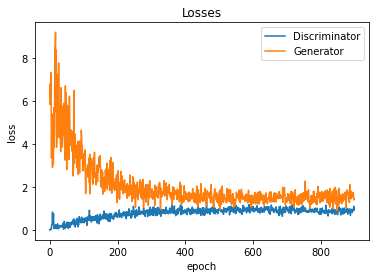

In [34]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

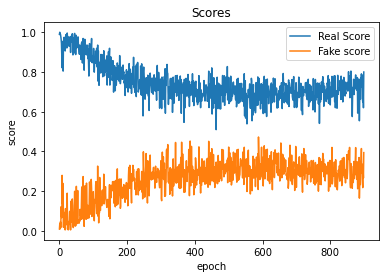

In [35]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [36]:
!pip install jovian --upgrade -q

In [37]:
import jovian